In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import random

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", DEVICE)

Using device: cpu


In [21]:
# =============================
# 1. Synthetic Dataset
# =============================
class SyntheticSRDataset(Dataset):
    def __init__(self, num_images=300, hr_size=96, scale=2):
        self.num_images = num_images
        self.hr_size = hr_size
        self.lr_size = hr_size // scale
        self.scale = scale
        self.to_tensor = transforms.ToTensor()
        self.resize_lr = transforms.Resize(
            (self.lr_size, self.lr_size),
            interpolation=transforms.InterpolationMode.BICUBIC
        )

    def _generate_hr_image(self):
        img = np.zeros((self.hr_size, self.hr_size, 3), dtype=np.float32)
        gx, gy = np.meshgrid(
            np.linspace(0, 1, self.hr_size),
            np.linspace(0, 1, self.hr_size)
        )
        img[..., 0] = gx
        img[..., 1] = gy
        img[..., 2] = 0.5 * gx + 0.5 * gy

        x = random.randint(10, self.hr_size - 30)
        y = random.randint(10, self.hr_size - 30)
        s = random.randint(10, 25)
        img[y:y+s, x:x+s, :] = np.random.rand(3)

        return img

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        hr = self.to_tensor(self._generate_hr_image())
        lr = self.resize_lr(hr)
        return lr, hr


In [22]:
# =============================
# 2. Model
# =============================
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return x + self.conv2(self.relu(self.conv1(x)))


class ViTBlock(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x


class CNNViTSR(nn.Module):
    def __init__(self, scale=2, channels=64, blocks=4):
        super().__init__()
        self.head = nn.Conv2d(3, channels, 3, padding=1)
        self.body = nn.Sequential(*[ResidualBlock(channels) for _ in range(blocks)])
        self.vit = ViTBlock(channels)
        self.fusion = nn.Conv2d(channels * 2, channels, 1)
        self.upsample = nn.Sequential(
            nn.Conv2d(channels, channels * scale * scale, 3, padding=1),
            nn.PixelShuffle(scale),
            nn.Conv2d(channels, 3, 3, padding=1)
        )

    def forward(self, x):
        feat = self.body(self.head(x))
        b, c, h, w = feat.shape

        vit_feat = feat.flatten(2).transpose(1, 2)
        vit_feat = self.vit(vit_feat)
        vit_feat = vit_feat.transpose(1, 2).view(b, c, h, w)

        fused = self.fusion(torch.cat([feat, vit_feat], dim=1))
        return self.upsample(fused)

In [23]:
# =============================
# 3. Training
# =============================
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for lr, hr in loader:
        lr, hr = lr.to(DEVICE), hr.to(DEVICE)
        optimizer.zero_grad()
        sr = model(lr)
        loss = loss_fn(sr, hr)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [24]:
# =============================
# 4. PSNR
# =============================
def psnr(sr, hr):
    mse = torch.mean((sr - hr) ** 2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

In [25]:
# =============================
# 5. Run Everything
# =============================
dataset = SyntheticSRDataset()
loader = DataLoader(dataset, batch_size=8, shuffle=True)

model = CNNViTSR().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.L1Loss()

epochs = 5
train_losses = []

for epoch in range(epochs):
    loss = train_one_epoch(model, loader, optimizer, loss_fn)
    train_losses.append(loss)
    print(f"Epoch [{epoch+1}/{epochs}] - L1 Loss: {loss:.4f}")

Epoch [1/5] - L1 Loss: 0.1550
Epoch [2/5] - L1 Loss: 0.0364
Epoch [3/5] - L1 Loss: 0.0285
Epoch [4/5] - L1 Loss: 0.0243
Epoch [5/5] - L1 Loss: 0.0209


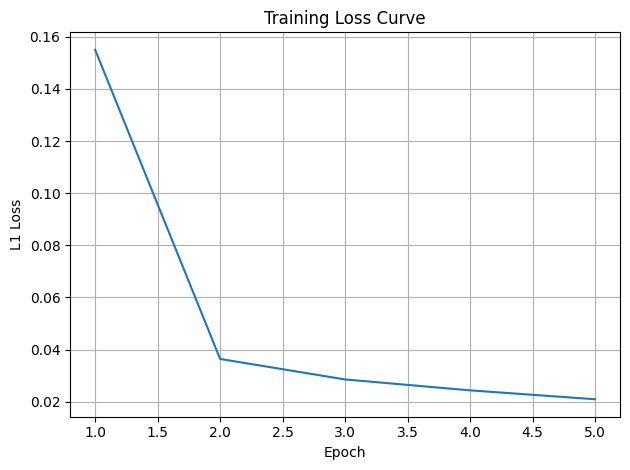

In [26]:
# =============================
# 6. Loss Curve Figure
# =============================
plt.figure()
plt.plot(range(1, epochs + 1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("L1 Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=300)
plt.show()

In [27]:
# =============================
# 7. PSNR Evaluation
# =============================
model.eval()
psnr_bicubic, psnr_sr = [], []

with torch.no_grad():
    for i in range(50):
        lr, hr = dataset[i]
        lr, hr = lr.unsqueeze(0).to(DEVICE), hr.unsqueeze(0).to(DEVICE)
        bicubic = F.interpolate(lr, size=hr.shape[-2:], mode='bicubic', align_corners=False)
        sr = model(lr)
        psnr_bicubic.append(psnr(bicubic, hr).item())
        psnr_sr.append(psnr(sr, hr).item())

print(f"Bicubic PSNR: {np.mean(psnr_bicubic):.2f} dB")
print(f"CNN–ViT PSNR: {np.mean(psnr_sr):.2f} dB")

Bicubic PSNR: 38.16 dB
CNN–ViT PSNR: 26.07 dB


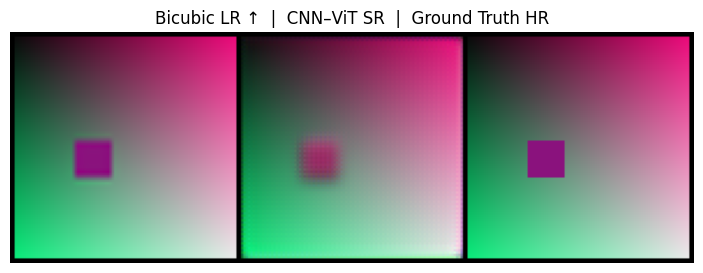

In [28]:
# =============================
# 8. SR Visualization
# =============================
lr, hr = dataset[0]
with torch.no_grad():
    sr = model(lr.unsqueeze(0).to(DEVICE)).cpu()

lr_up = F.interpolate(lr.unsqueeze(0), size=hr.shape[-2:], mode='bicubic', align_corners=False)
imgs = torch.cat([lr_up, sr, hr.unsqueeze(0)], dim=0)
grid = make_grid(imgs, nrow=3, normalize=True)

plt.figure(figsize=(9, 3))
plt.imshow(grid.permute(1, 2, 0))
plt.title("Bicubic LR ↑  |  CNN–ViT SR  |  Ground Truth HR")
plt.axis("off")
plt.savefig("sr_results.png", dpi=300)
plt.show()